### import necessary packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import anndata as ad
import scanpy as sc
import pandas as pd
import os
import numpy as np
from scipy import sparse

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

In [2]:
# get cuda version (oue device is 12, some new device may be 13)
! nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


### Check jax device on cuda or cpu. If you hava cuda device and result is cpu, please consider: pip install --upgrade "jax[cuda12]". (cuda version can be 12 or 13)

In [3]:
import jax

jax.default_backend(), device

('gpu', device(type='cuda', index=0))

### Load Data

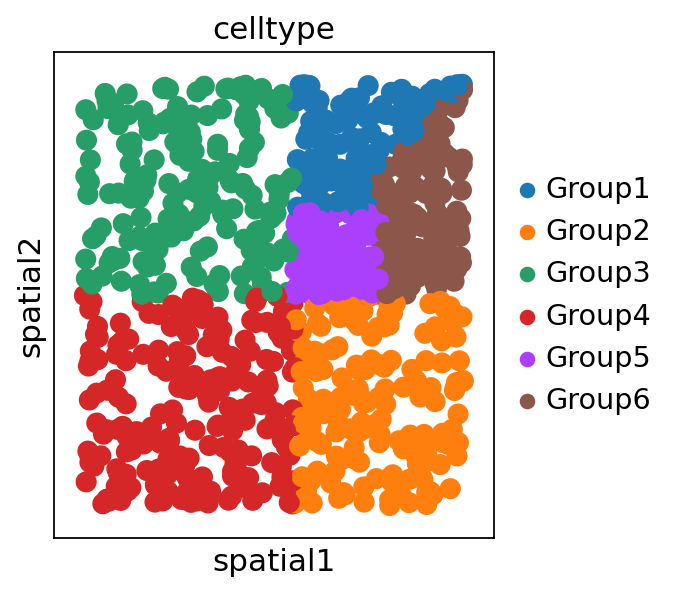

Calculating spatial neighbor graph ...
The graph contains 2368 edges, 500 cells
4.736 neighbors per cell on average
Calculating spatial neighbor graph ...
The graph contains 2396 edges, 500 cells
4.792 neighbors per cell on average


In [10]:
from aligndg.utils import graph_construction

adata = sc.read_h5ad('data/Simulation/simulate1.h5ad')
sc.pl.spatial(adata, color=['celltype'], spot_size=0.5)
adata_sub1 = adata[adata.obs['batch'] == 'Batch1']
adata_sub2 = adata[adata.obs['batch'] == 'Batch2']

adj_list = []
section_ids = ['Batch1', 'Batch2']
adata_list = [adata_sub1, adata_sub2]
for i in range(len(adata_list)):
    adata_list[i].X = sparse.csc_matrix(adata_list[i].X)
    adata_list[i].var_names_make_unique(join="++")
    adata_list[i].obs_names = [x + '_' + section_ids[i] for x in adata_list[i].obs_names]
    graph_construction.cal_spatial_network(adata_list[i], model='KNN', k_cutoff=4)
    adj_list.append(adata_list[i].uns['adj'])

In [11]:
adata1_harm_df = pd.DataFrame({
    'index': range(adata_sub1.shape[0]),
    'x': adata_sub1.obsm['spatial'][:, 0],
    'y': adata_sub1.obsm['spatial'][:, 1],
    'domain': adata_sub1.obs['celltype'].astype('category'),
})

adata2_harm_df = pd.DataFrame({
    'index': range(adata_sub2.shape[0]),
    'x': adata_sub2.obsm['spatial'][:, 0],
    'y': adata_sub2.obsm['spatial'][:, 1],
    'domain': adata_sub2.obs['celltype'].astype('category'),
})

adata1_harm_df, adata2_harm_df

(                index         x         y  domain
 Cell1_Batch1        0  1.037015  0.727646  Group3
 Cell2_Batch1        1  7.301914  9.436571  Group2
 Cell3_Batch1        2  5.493741  5.021805  Group2
 Cell4_Batch1        3  6.041019  9.825238  Group2
 Cell5_Batch1        4  6.947731  4.347541  Group5
 ...               ...       ...       ...     ...
 Cell496_Batch1    495  0.048206  9.434689  Group4
 Cell497_Batch1    496  7.969817  7.419835  Group2
 Cell498_Batch1    497  3.112033  2.076640  Group3
 Cell499_Batch1    498  7.234705  9.352265  Group2
 Cell500_Batch1    499  5.126478  8.129682  Group2
 
 [500 rows x 4 columns],
                  index         x         y  domain
 Cell501_Batch2       0  7.181161  5.700499  Group2
 Cell502_Batch2       1  7.951904  0.702857  Group1
 Cell503_Batch2       2  5.376372  0.877961  Group1
 Cell504_Batch2       3  0.054656  1.326532  Group3
 Cell505_Batch2       4  6.388294  8.878522  Group2
 ...                ...       ...       ...     .

In [12]:
from scipy.sparse import block_diag

adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
adj_concat = block_diag(adj_list)
adata_concat.uns['edge_list'] = np.nonzero(adj_concat)
adata_concat

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'celltype', 'batch', 'slice_name', 'batch_name'
    uns: 'edge_list'
    obsm: 'spatial'

### Perform AlignDG

In [16]:
from aligndg.graph import AlignDG

adata_concat, pis = AlignDG.train_AlignDG(adata=adata_concat, beta=0.5, iter_comb=[(0, 1)])

  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplet at epoch 500
Processing datasets ('Batch1', 'Batch2')
Solver may not converge.


# Epoch 599, loss: 0.632, gene_recon: 0.586, triplet loss: 0.04584432393312454:  20%|█▉        | 98/500 [00:08<00:07, 55.81it/s] 

Update spot triplet at epoch 600
Processing datasets ('Batch1', 'Batch2')


# Epoch 608, loss: 0.795, gene_recon: 0.640, triplet loss: 0.15412934124469757:  21%|██        | 106/500 [00:13<01:06,  5.90it/s]

Solver may not converge.


# Epoch 699, loss: 0.734, gene_recon: 0.712, triplet loss: 0.02233678475022316:  40%|████      | 200/500 [00:14<00:04, 70.11it/s] 

Update spot triplet at epoch 700
Processing datasets ('Batch1', 'Batch2')


# Epoch 709, loss: 0.708, gene_recon: 0.600, triplet loss: 0.10783737897872925:  42%|████▏     | 209/500 [00:18<00:43,  6.70it/s]

Solver may not converge.


# Epoch 799, loss: 0.518, gene_recon: 0.482, triplet loss: 0.036520037800073624:  60%|█████▉    | 299/500 [00:19<00:03, 60.66it/s]

Update spot triplet at epoch 800
Processing datasets ('Batch1', 'Batch2')


# Epoch 807, loss: 0.606, gene_recon: 0.498, triplet loss: 0.10765905678272247:  61%|██████    | 306/500 [00:23<00:35,  5.51it/s] 

Solver may not converge.


# Epoch 899, loss: 0.480, gene_recon: 0.455, triplet loss: 0.024372799322009087:  79%|███████▉  | 395/500 [00:25<00:01, 59.87it/s]

Update spot triplet at epoch 900
Processing datasets ('Batch1', 'Batch2')


# Epoch 908, loss: 0.644, gene_recon: 0.522, triplet loss: 0.12167825549840927:  80%|████████  | 402/500 [00:29<00:20,  4.87it/s] 

Solver may not converge.


# Epoch 999, loss: 0.446, gene_recon: 0.426, triplet loss: 0.020836396142840385: 100%|██████████| 500/500 [00:31<00:00, 15.99it/s]


In [17]:
# calculate mapping acc

mapping_pi = pis[0]
count = 0
ref_raw_list = []
index = []
for i in range(mapping_pi.shape[0]):
    if np.sum(mapping_pi[i] > 0):
        index.append(i)
        source_domain = adata_sub1.obs['celltype'][i]
        max_align = mapping_pi[i].argsort()[-1]
        target_domain = adata_sub2.obs['celltype'].values[max_align]
        ref_raw_list.append(max_align)
        if source_domain == target_domain:
            count = count + 1

print(count / len(ref_raw_list), count, len(ref_raw_list))

0.962 481 500


### Visualization mapping result

dataset1: 6 cell types; dataset2: 6 cell types; 
                    Total :6 celltypes; Overlap: 6 cell types 
                    Not overlap :[[]]
Subsampled 150 pairs from 500


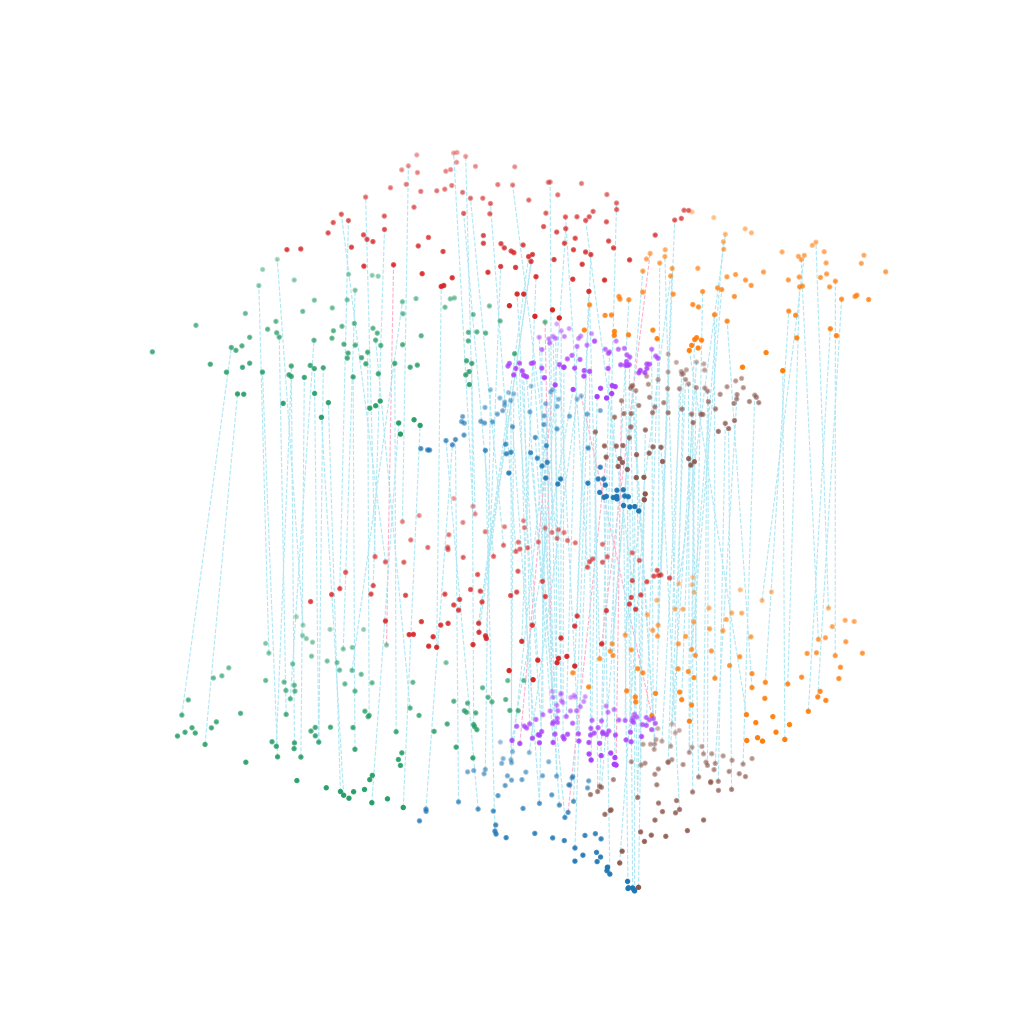

In [18]:
from aligndg.utils.visualize import Build3D

index_harm = np.array(ref_raw_list)
matching_harm = np.array([index, index_harm])

multi_align = Build3D(adata2_harm_df, adata1_harm_df, matching_harm, meta='domain', scale_coordinate=True,subsample_size=150, exchange_xy=False)
multi_align.draw_3D(size=[8, 10], line_width=0.5, point_size=[2, 2], line_alpha=1, hide_axis=True, show_error=True)